# DC v2

Perform more MDAC sweeps measuring with the lockin.

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm.notebook import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from september.retort import Retort

from may.custom_devices import connect_to_gb, newSiDot
from qcodes.instrument_drivers.stanford_research.SR860 import SR860

In [4]:
##%% Connect to instruments
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("lockin")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name lockin. Does not exist")

#scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

#lockin = scfg.load_instrument('sr860_top')
#psg = scfg.load_instrument('PSG')

lockin = SR860('lockin', 'TCPIP::192.168.0.108::inst0::INSTR')
#psg = E8267('psg', 'TCPIP0::192.168.0.109::inst0::INSTR')


gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.23s
Cannot remove instrument with name lockin. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.10s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [9]:
# Disconnect from all devices
disconnect = True
if disconnect:
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("lockin")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")
    try:
        psg = Instrument.find_instrument("psg")
        psg.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')

Attempting to remove instrument with name mdac. Does not exist
Cannot remove instrument with name sr860_top. Does not exist
Attempting to remove instrument with name mdac. Does not exist


In [6]:
experiment = {
    "desc": "Measure detuning using RF and DC methods"
}

monty = Monty("summary.stability", experiment)

[2024-09-16 11:09:23,279] INFO Loading existing experiment (ignoring given experiment parameters)
[2024-09-16 11:09:23,300] WARNING Note that no experimental data has been loaded.
[2024-09-16 11:09:23,301] INFO Next run will have id 4


In [5]:
dots.get_all_voltages(mdac)

LCB:   0.150004 V
RCB:   0.150003 V
RG:    0.0 V
ResB:  0.0 V
P3:    0.0 V
P2:    1.299998 V
P1:    1.299996 V
SETB:  1.099999 V
SRB:   0.900001 V
SLB:   0.899997 V
ST:    3.300013 V
bias:  0.0 V
VSS1P8:      0.0 V
VSS1P0:      0.0 V
VDD1P8:      1.800005 V
VDD1P0:      0.999996 V
VDD1P8_ANA:  1.8 V
BGN1P0:      0.0 V
BGN1P8:      0.0 V
BGP1P0:      0.0 V
BGP1P8:      0.0 V
RST:         1.799996 V
MOSI:        0.0 V
SCLK:        0.0 V
SS_N:        1.8 V
APBCLK:      0.0 V
VICL:        3.500004 V
VLFG:        0.0 V
VHFG:        0.0 V


In [129]:
si.ST(3.414399)

## Coulomb SET sweep (1D)

[2024-09-17 17:34:13,571] INFO Started new run SET_ST_sweep.13
Sweeping Si28_quantum_dot_ST from 3.2V to 3.5V in 401 points.


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 17:37:04,450] INFO Run finished and took 0:02:50.879451.
[2024-09-17 17:37:04,451] INFO Saving to SET_ST_sweep.13.xz
[2024-09-17 17:37:04,469] INFO Saving to experiment.yaml


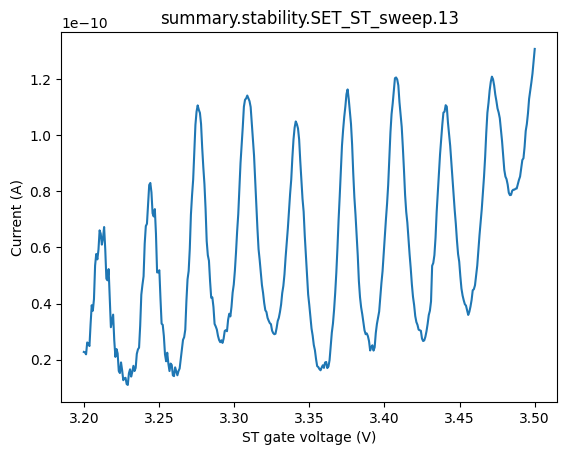

In [138]:
low = 3.2
high = 3.5
pts = 401

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty) 

monty.save(result)

## Feedback Functions

Restructure how we do feedback. Make a class that controls everything

In [11]:
retort = Retort(
    target=6e-11,
    stepsize=5e-4
)

In [22]:
si.ST(3.6)

In [23]:
retort.get_to_target(si, lockin)

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.600002
ST = 3.6041e+00, lockin = 5.0866e-11, delta = 9.1131e-12
Final ST = 3.604138


In [33]:
retort.move_with_feedback(si, lockin, si.SETB, end=0.00, dx=0.001)

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.499999
SETB = 0.0000e+00, ST = 3.5011e+00, lockin = 4.5447e-11, delta = 1.4648e-11
Final ST = 3.502907


In [32]:
si.SETB()

0.009997

In [31]:
np.arange(10, 5-1, -1)

array([10,  9,  8,  7,  6,  5])

## Sweep Antidetuning vs setb (2D)

In [59]:
def sweep_anti_detuning_vs_setb(p_points, setb_points):
    """Measure electrons entering and exiting the double dot. Note the asymmetry when loading/unload the dots. Find a region of SETB where it is similar."""
    p_low, p_high, p_pts = p_points
    setb_low, setb_high, setb_pts = setb_points
    parameters = {
        "desc": "Sweep anti detuning axis (P1 + P2) (feedback)",
        "lockin_amplitude": f"Set to {lockin.amplitude()} V (with divider)",
        "ST":   f"Fixed at {si.ST()}V (target of {retort.target} on lockin, stepsize = {retort.stepsize})",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        "P1": f"Ranged from {p_low}V -> {p_high}V in {p_pts} points",
        "P2": f"Ranged from {p_low}V -> {p_high}V in {p_pts} points",
        "SETB": f"Ranged from {setb_low} -> {setb_high} in {setb_pts} points",
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun("anti detuning loading", parameters)
    
    # gate voltage
    p_range = np.linspace(p_low, p_high, p_pts)
    setb_range = np.linspace(setb_low, setb_high, setb_pts)
    
    X = np.zeros((setb_pts, p_pts))
    Y = np.zeros((setb_pts, p_pts))
    R = np.zeros((setb_pts, p_pts))
    P = np.zeros((setb_pts, p_pts))
    ST_drift = np.zeros((setb_pts, p_pts))
    
    I = np.arange(p_pts)  # indices for datapoints
    
    with tqdm(total=setb_pts*p_pts) as pbar, LiveContourPlot(p_range, setb_range, xlabel="Antidetuning (V)", ylabel="SETB (V)") as lplot:
        for (j, setb) in enumerate(setb_range):
            
            # Set the new barrier gate
            retort.move_with_feedback(si, lockin, si.SETB, end=setb, dx=0.001, progress=False)
            #si.SETB(setb)
            
            time.sleep(1.0)  # ALlow any transitions to occur now
            
            for i in I:
                p = p_range[i]
                si.P1(p)
                si.P2(p)
                time.sleep(0.3)
                
                X[j, i] = lockin.X()
                Y[j, i] = lockin.Y()
                R[j, i] = lockin.R()
                P[j, i] = lockin.P()
                ST_drift[j, i] = si.ST()
                
                pbar.update(1)
                lplot.update(R)
                
                retort.feedback(si, lockin)
                
            monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST_drift": ST_drift})
            I = I[::-1]  # flip the next direction
            
    monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
    
    swiper.plotsweep2d(setb_range, p_range, R, "SETB", "Antidetuning", monty)  # note wont separate directions
    swiper.plotsweep2d(setb_range[::2], p_range, R[::2, :], "SETB", "Antidetuning", extra_title=".forward", monty=monty)
    swiper.plotsweep2d(setb_range[1::2], p_range, R[1::2, :], "SETB", "Antidetuning", extra_title=".backward", monty=monty)

    return {"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}
    

In [87]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")

ST = 3.385427
SLB = 0.899997
SRB = 0.900001
P1 = 1.574004
P2 = 1.574005
SETB = 0.284383


In [39]:
# Unload any electrons
si.P1(1.0)
si.P2(1.0)
time.sleep(5)

In [72]:
si.ST(3.366515)

In [67]:
retort.get_to_target(si, lockin, progress=True)

ST = 3.5013e+00, lockin = 6.6413e-11, delta = 6.3168e-12


In [68]:
0.2/51

0.00392156862745098

In [74]:
p_low = 1.3
p_high = 1.6
p_pts = 301

setb_low = 0.4
setb_high = 0.2
setb_pts = 151

# Setup gates correctly
retort.move_with_feedback(si, lockin, si.P1, end=p_low)
retort.move_with_feedback(si, lockin, si.P2, end=p_low)
retort.move_with_feedback(si, lockin, si.SETB, end=setb_low)
time.sleep(5)

# Get to SET target
retort.get_to_target(si, lockin)
time.sleep(1)

result = sweep_anti_detuning_vs_setb((p_low, p_high, p_pts), (setb_low, setb_high, setb_pts))

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.366515
ST = 3.3547e+00, lockin = 6.6846e-11, delta = 6.8315e-12elta = 2.3638e-11
ST = 3.3544e+00, lockin = 6.9113e-11, delta = 9.0638e-12elta = 1.0299e-11

Final ST = 3.354362
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.354362
P2 = 1.3000e+00, ST = 3.3544e+00, lockin = 6.7840e-11, delta = 7.8187e-12
P2 = 1.3100e+00, ST = 3.3544e+00, lockin = 6.7341e-11, delta = 7.3944e-12

Final ST = 3.354362
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.354362
ST = 3.3540e+00, lockin = 6.9274e-11, delta = 9.2248e-12 delta = 1.0689e-11
SETB = 3.9023e-01, ST = 3.3540e+00, lockin = 6.5870e-11, delta = 5.5267e-12

Final ST = 3.353998
ST = 3.3590e+00, lockin = 4.9853e-11, delta = 1.0064e-11
[2024-09-16 23:07:10,277] INFO Started new run anti_detuning_loading.5


  0%|          | 0/45451 [00:00<?, ?it/s]

Aborting feedback: correction voltage fails to meet threshold, 3.2999539643510416 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.29995404374355 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999514022222916 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.299945345088325 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999486392703834 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999393785069335 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.2999477352481583 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.29995552820425 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet threshold, 3.299937232133575 < 3.3. No change to ST.
Aborting feedback: correction voltage fails to meet 

KeyboardInterrupt: 

## Sweep detuning or antidetuning (1D)

In [89]:
def two_gate_sweep(g1_params, g2_params, pts):
    g1, g1_low, g1_high = g1_params
    g2, g2_low, g2_high = g2_params
    
    parameters = {
        "desc": "Sweep detuning axis (P1 - P2) (feedback)",
        "lockin_amplitude": "Set to 10uV",
        "ST":   f"Fixed at {si.ST()}V (target of {retort.target} on lockin, stepsize = {retort.stepsize})",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "SETB": f"Fixed at {si.SETB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        g1.name: f"Ranged from {g1_low}V -> {g1_high}V in {pts} points",  # P1 or P2
        g2.name: f"Ranged from {g2_low}V -> {g2_high}V in {pts} points",  # P1 or P2
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun(f"{g1.name} vs {g2.name} scan", parameters)
    
    # gate voltages
    g1_range = np.linspace(g1_low, g1_high, pts)
    g2_range = np.linspace(g2_low, g2_high, pts)
    I = np.arange(pts)
    
    X = np.zeros((pts))
    Y = np.zeros((pts))
    R = np.zeros((pts))
    P = np.zeros((pts))
    ST_drift = np.zeros(pts)
    
    with tqdm(total=pts) as pbar, LivePlot(g1_range, xlabel=f"{g1.name} V", ylabel="Current (A)") as lplot:
        for i in I:
            g1(g1_range[i])
            g2(g2_range[i])
            time.sleep(0.5)
            
            ST_drift[i] = si.ST()
            X[i] = lockin.X()
            Y[i] = lockin.Y()
            R[i] = lockin.R()
            P[i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            retort.feedback(si, lockin)
    
    monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})

    return {"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}

In [123]:
def plot_detuning(g1_params, g2_params, R, ST_drift):
    """Plot the detuning axis plot"""
    g1, g1_low, g1_high = g1_params
    g2, g2_low, g2_high = g2_params
    
    R = result["R"]
    ST_drift = result["ST"]
    
    detuning = np.linspace((g1_low-g2_low)/np.sqrt(2), (g1_high-g2_high)/np.sqrt(2), len(R))
    
    fig, ax0 = plt.subplots()
    ax1 = ax0.twinx()
    
    ax0.plot(detuning, R, "g-", label="Lockin")
    ax0.grid()
    ax0.set_ylabel("Lockin (A)", color="g")
    ax0.set_xlabel("Detuning (V)")
    
    # Plot ST history over time
    ax1.plot(detuning, ST_drift, "r-", label="ST gate")
    ax1.set_ylabel("ST voltage (V)", color="r")
    
    ax0.set_title(monty.identifier + "." + monty.runname)
    
    fig.tight_layout()
    monty.savefig(plt, "detuning")

In [139]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")
print(f"J = {gb_control_si.VICL()}\n")

ST = 3.499999
SLB = 0.899997
SRB = 0.900001
P1 = 1.599999
P2 = 1.400002
SETB = 0.564384
J = 3.500004



In [132]:
retort.lower_bound

3.0

In [141]:
si.ST(3.332)

In [142]:
retort.get_to_target(si, lockin)

In [94]:

retort.move_with_feedback(si, lockin, si.SETB, end=0.34)

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.385004
SETB = 2.8438e-01, ST = 3.3850e+00, lockin = 5.4959e-11, delta = 5.0091e-12
SETB = 2.9438e-01, ST = 3.3850e+00, lockin = 5.8862e-11, delta = 8.9574e-13
ST = 3.4015e+00, lockin = 5.1542e-11, delta = 8.4336e-12 delta = 2.6384e-11
SETB = 3.1438e-01, ST = 3.4015e+00, lockin = 6.0200e-11, delta = 7.0214e-13
ST = 3.4017e+00, lockin = 6.2241e-11, delta = 2.4844e-12 delta = 3.7112e-11
SETB = 3.3438e-01, ST = 3.4017e+00, lockin = 6.1553e-11, delta = 1.1403e-12
ST = 3.4055e+00, lockin = 5.1511e-11, delta = 8.4559e-12 delta = 3.1096e-11

Final ST = 3.405459


In [146]:
[1,2,3][::-1]

[3, 2, 1]

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.332001
SETB = 5.6438e-01, ST = 3.3320e+00, lockin = 5.0447e-11, delta = 9.5342e-12
ST = 3.3392e+00, lockin = 5.1607e-11, delta = 8.4089e-12 delta = 2.0638e-11
ST = 3.3469e+00, lockin = 5.3479e-11, delta = 6.4667e-12 delta = 1.0492e-11

Final ST = 3.346925
[2024-09-17 17:47:12,008] INFO Started new run P1_vs_P2_scan.8


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 17:55:04,205] INFO Run finished and took 0:07:52.196345.
[2024-09-17 17:55:04,206] INFO Saving to P1_vs_P2_scan.8.xz
[2024-09-17 17:55:04,226] INFO Saving to experiment.yaml


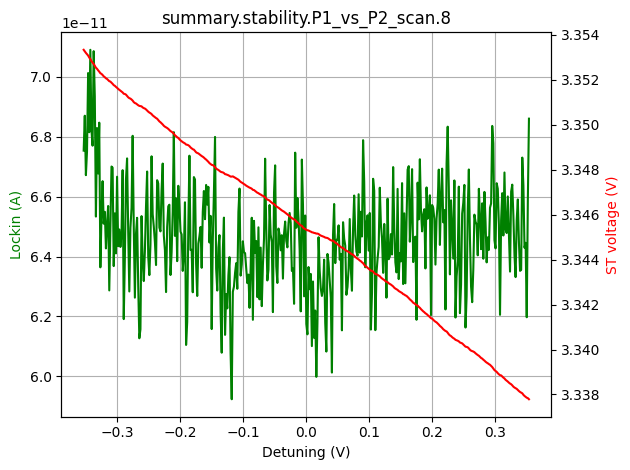

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.337719
SETB = 5.4438e-01, ST = 3.3377e+00, lockin = 6.5182e-11, delta = 5.1616e-12
SETB = 5.3438e-01, ST = 3.3377e+00, lockin = 6.2580e-11, delta = 2.0775e-12
ST = 3.3507e+00, lockin = 5.1451e-11, delta = 8.5295e-12 delta = 2.6869e-11
SETB = 5.1438e-01, ST = 3.3507e+00, lockin = 5.2567e-11, delta = 7.5635e-12
ST = 3.3642e+00, lockin = 4.9654e-11, delta = 1.0254e-11 delta = 3.1800e-11
ST = 3.3715e+00, lockin = 5.0047e-11, delta = 9.9007e-12 delta = 1.3062e-11

Final ST = 3.371466
[2024-09-17 17:59:07,181] INFO Started new run P1_vs_P2_scan.9


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 18:07:00,605] INFO Run finished and took 0:07:53.424344.
[2024-09-17 18:07:00,605] INFO Saving to P1_vs_P2_scan.9.xz
[2024-09-17 18:07:00,637] INFO Saving to experiment.yaml


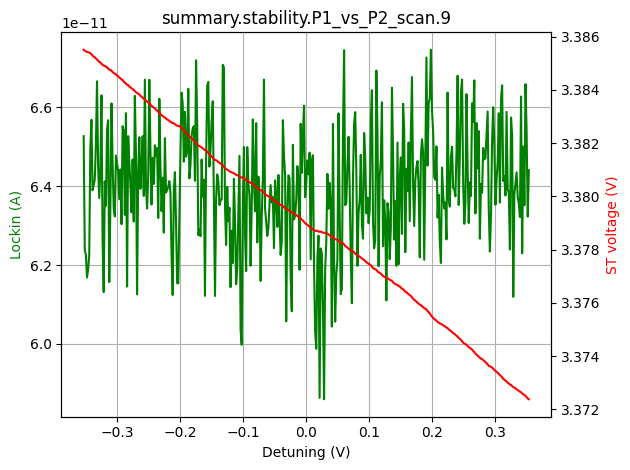

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.372341
SETB = 4.9438e-01, ST = 3.3723e+00, lockin = 6.4348e-11, delta = 4.2966e-12
SETB = 4.8438e-01, ST = 3.3723e+00, lockin = 6.2508e-11, delta = 2.2848e-12
ST = 3.3847e+00, lockin = 5.1825e-11, delta = 8.1334e-12 delta = 3.1477e-11
SETB = 4.6438e-01, ST = 3.3847e+00, lockin = 5.4432e-11, delta = 5.6735e-12
ST = 3.3970e+00, lockin = 5.0060e-11, delta = 9.8488e-12 delta = 2.7112e-11
ST = 3.4031e+00, lockin = 5.1589e-11, delta = 8.4237e-12 delta = 1.2411e-11

Final ST = 3.40313
[2024-09-17 18:10:18,029] INFO Started new run P1_vs_P2_scan.10


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 18:18:10,609] INFO Run finished and took 0:07:52.580313.
[2024-09-17 18:18:10,610] INFO Saving to P1_vs_P2_scan.10.xz
[2024-09-17 18:18:10,659] INFO Saving to experiment.yaml


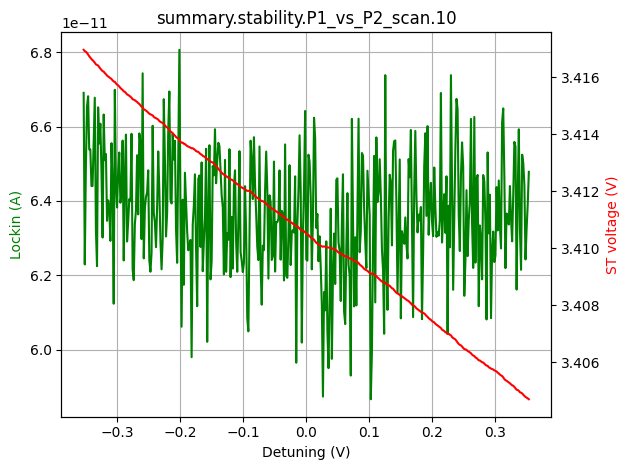

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.404673
SETB = 4.4438e-01, ST = 3.4047e+00, lockin = 6.5203e-11, delta = 5.2277e-12
SETB = 4.3438e-01, ST = 3.4047e+00, lockin = 6.2814e-11, delta = 2.7378e-12
ST = 3.4049e+00, lockin = 5.4353e-11, delta = 5.4061e-12 delta = 1.5128e-11
SETB = 4.1438e-01, ST = 3.4049e+00, lockin = 6.1122e-11, delta = 1.3587e-12
ST = 3.3990e+00, lockin = 6.9626e-11, delta = 9.6192e-12 delta = 2.1999e-11
ST = 3.3988e+00, lockin = 6.9862e-11, delta = 9.8538e-12 delta = 1.0458e-11

Final ST = 3.398847
[2024-09-17 18:20:57,357] INFO Started new run P1_vs_P2_scan.11


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 18:28:50,723] INFO Run finished and took 0:07:53.366225.
[2024-09-17 18:28:50,724] INFO Saving to P1_vs_P2_scan.11.xz
[2024-09-17 18:28:50,740] INFO Saving to experiment.yaml


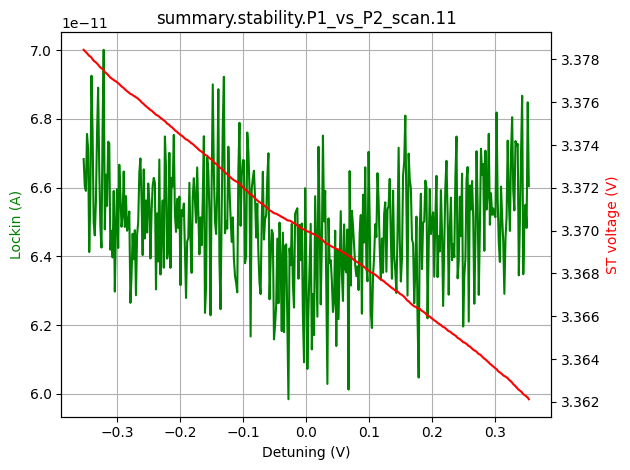

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.362074
SETB = 3.9437e-01, ST = 3.3621e+00, lockin = 6.7319e-11, delta = 7.3661e-12
SETB = 3.8438e-01, ST = 3.3621e+00, lockin = 6.5251e-11, delta = 5.0800e-12
SETB = 3.7437e-01, ST = 3.3621e+00, lockin = 5.2816e-11, delta = 7.2127e-12
SETB = 3.6438e-01, ST = 3.3621e+00, lockin = 6.3235e-11, delta = 3.5211e-12
ST = 3.3605e+00, lockin = 6.9106e-11, delta = 9.1217e-12 delta = 4.0677e-11
SETB = 3.4437e-01, ST = 3.3605e+00, lockin = 6.4099e-11, delta = 3.8708e-12

Final ST = 3.360492
[2024-09-17 18:32:36,196] INFO Started new run P1_vs_P2_scan.12


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 18:40:27,896] INFO Run finished and took 0:07:51.700734.
[2024-09-17 18:40:27,897] INFO Saving to P1_vs_P2_scan.12.xz
[2024-09-17 18:40:27,912] INFO Saving to experiment.yaml


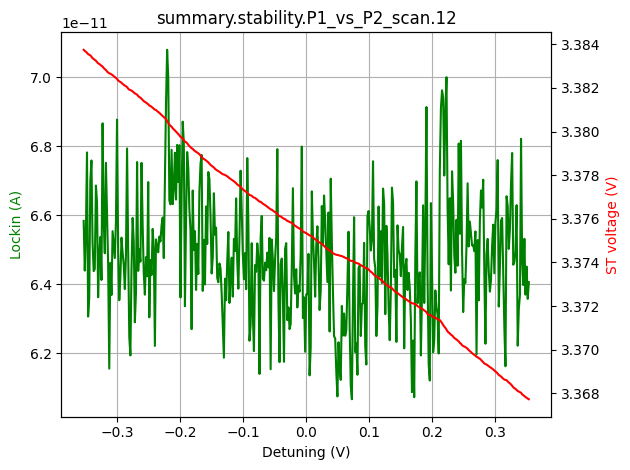

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.367703
SETB = 3.4437e-01, ST = 3.3677e+00, lockin = 6.5587e-11, delta = 5.5753e-12
SETB = 3.3438e-01, ST = 3.3677e+00, lockin = 6.2417e-11, delta = 2.2263e-12
ST = 3.3825e+00, lockin = 5.0450e-11, delta = 9.4635e-12 delta = 2.7347e-11
SETB = 3.1437e-01, ST = 3.3825e+00, lockin = 5.0949e-11, delta = 9.2779e-12
ST = 3.3947e+00, lockin = 5.1293e-11, delta = 8.5684e-12 delta = 3.1170e-11
ST = 3.4024e+00, lockin = 5.0359e-11, delta = 9.5260e-12 delta = 1.0050e-11

Final ST = 3.402354
[2024-09-17 18:44:18,059] INFO Started new run P1_vs_P2_scan.13


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 18:52:10,476] INFO Run finished and took 0:07:52.417436.
[2024-09-17 18:52:10,477] INFO Saving to P1_vs_P2_scan.13.xz
[2024-09-17 18:52:10,494] INFO Saving to experiment.yaml


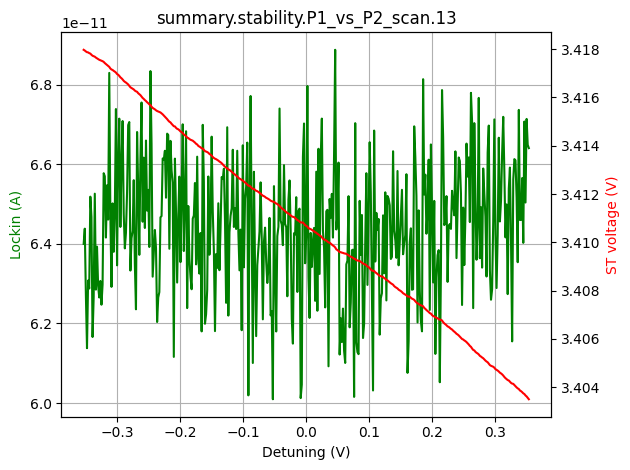

In [147]:
for setb in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55][::-1]:
    retort.move_with_feedback(si, lockin, si.SETB, end=setb)
    
    g1_params = (si.P1, 1.3, 1.8)
    g2_params = (si.P2, 1.8, 1.3)
    
    pts = 401
    
    retort.move_with_feedback(si, lockin, g1_params[0], end=g1_params[1], progress=False)
    retort.move_with_feedback(si, lockin, g2_params[0], end=g2_params[1], progress=False)
    time.sleep(5)
    
    result = two_gate_sweep(g1_params, g2_params, pts)
    plot_detuning(g1_params, g2_params, result["R"], result["ST"])
    plt.show()

Target = 6.0000e-11, tol = 1e-11, initial ST = 3.389897
SETB = 4.0438e-01, ST = 3.3899e+00, lockin = 6.2816e-11, delta = 2.8015e-12
SETB = 4.1438e-01, ST = 3.3899e+00, lockin = 6.5713e-11, delta = 5.7570e-12
SETB = 4.2438e-01, ST = 3.3899e+00, lockin = 6.3073e-11, delta = 2.9275e-12
SETB = 4.3438e-01, ST = 3.3899e+00, lockin = 5.5169e-11, delta = 4.8358e-12
ST = 3.3829e+00, lockin = 6.9836e-11, delta = 9.7695e-12 delta = 1.5326e-11
ST = 3.3763e+00, lockin = 6.9785e-11, delta = 9.7621e-12 delta = 1.0975e-11

Final ST = 3.37628
[2024-09-17 16:01:04,363] INFO Started new run P1_vs_P2_scan.4


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 16:08:59,418] INFO Run finished and took 0:07:55.054759.
[2024-09-17 16:08:59,419] INFO Saving to P1_vs_P2_scan.4.xz
[2024-09-17 16:08:59,440] INFO Saving to experiment.yaml
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.375366
SETB = 4.5438e-01, ST = 3.3754e+00, lockin = 5.9725e-11, delta = 3.3482e-13
SETB = 4.6438e-01, ST = 3.3754e+00, lockin = 6.2406e-11, delta = 2.9276e-12
ST = 3.3627e+00, lockin = 7.0045e-11, delta = 1.0002e-11 delta = 3.8877e-11
ST = 3.3556e+00, lockin = 6.8572e-11, delta = 8.5257e-12 delta = 1.1016e-11
SETB = 4.9438e-01, ST = 3.3556e+00, lockin = 6.8310e-11, delta = 8.7753e-12
ST = 3.3549e+00, lockin = 6.9314e-11, delta = 8.7327e-12 delta = 4.0549e-11

Final ST = 3.354941
[2024-09-17 16:10:56,430] INFO Started new run P1_vs_P2_scan.5


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 16:18:50,071] INFO Run finished and took 0:07:53.640461.
[2024-09-17 16:18:50,072] INFO Saving to P1_vs_P2_scan.5.xz
[2024-09-17 16:18:50,102] INFO Saving to experiment.yaml
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.340863
SETB = 5.0438e-01, ST = 3.3409e+00, lockin = 6.1190e-11, delta = 1.0832e-12
SETB = 5.1438e-01, ST = 3.3409e+00, lockin = 6.4469e-11, delta = 5.1999e-12
ST = 3.3401e+00, lockin = 7.4746e-11, delta = 1.3934e-11 delta = 4.3836e-11
SETB = 5.3438e-01, ST = 3.3401e+00, lockin = 6.4537e-11, delta = 4.3928e-12
ST = 3.3446e+00, lockin = 5.0364e-11, delta = 9.6168e-12 delta = 2.5454e-11
SETB = 5.5439e-01, ST = 3.3446e+00, lockin = 5.6764e-11, delta = 2.9536e-12

Final ST = 3.344606
[2024-09-17 16:20:22,038] INFO Started new run P1_vs_P2_scan.6


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 16:28:14,807] INFO Run finished and took 0:07:52.769212.
[2024-09-17 16:28:14,808] INFO Saving to P1_vs_P2_scan.6.xz
[2024-09-17 16:28:14,824] INFO Saving to experiment.yaml
Target = 6.0000e-11, tol = 1e-11, initial ST = 3.339301
SETB = 5.5439e-01, ST = 3.3393e+00, lockin = 6.1781e-11, delta = 1.7546e-12
SETB = 5.6438e-01, ST = 3.3393e+00, lockin = 6.3473e-11, delta = 3.7560e-12

Final ST = 3.339301
[2024-09-17 16:29:39,285] INFO Started new run P1_vs_P2_scan.7


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-17 16:37:32,103] INFO Run finished and took 0:07:52.817908.
[2024-09-17 16:37:32,104] INFO Saving to P1_vs_P2_scan.7.xz
[2024-09-17 16:37:32,119] INFO Saving to experiment.yaml


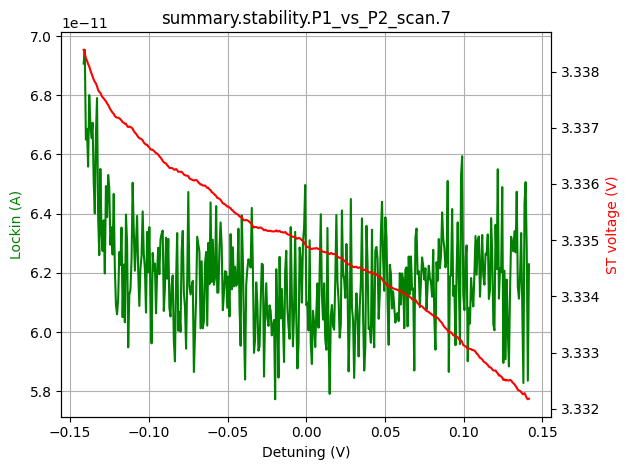

In [136]:
for setb in [0.45, 0.5, 0.55, 0.56]:
    retort.move_with_feedback(si, lockin, si.SETB, end=setb)
    
    g1_params = (si.P1, 1.4, 1.6)
    g2_params = (si.P2, 1.6, 1.4)
    
    pts = 401
    
    retort.move_with_feedback(si, lockin, g1_params[0], end=g1_params[1], progress=False)
    retort.move_with_feedback(si, lockin, g2_params[0], end=g2_params[1], progress=False)
    time.sleep(5)
    
    result = two_gate_sweep(g1_params, g2_params, pts)
    plot_detuning(g1_params, g2_params, result["R"], result["ST"])

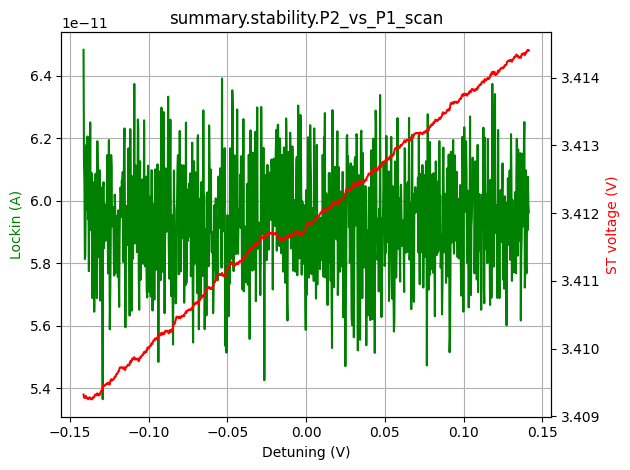